

Per il coach che correggera' questo progetto:

1. Il progetto viene mostrato seguendo la pipeline standard, dagli imports alla discussione finale. Ho inserito alcuni capitoli iniziali con delle funzioni costruite da me. Ognuna ha un'accurata documentazione. In particolare:

- (-1): contiene installazioni ed imports necessari;

- (0-A): contiene la definizione della classe per l'Early Stopping;

- (0-B): contiene tutto ciò che è necessario per eseguire il training di un modello ed analizzare i risultati. La sottodivisione riguarda funzioni da usare sul train e validation set oppure sul test set. Inoltre durante il training vengono automaticamente salvate tutte le quantità necessarie per visualizzare i plot del training (funzione `training_results`) ed a studiare le metriche successivamente (funzioni `plot_confusion_matrix` e `metrics_report`);

2. Ho impostato il notebook in modo estremamente didattico, con spiegazioni dettagliate di ogni passaggio (probabilmente spiegazioni ridondanti, ma meglio abbondare in questo contesto).

3. Non ho utilizzato K-fold cross-validation (come sarebbe giusto) per motivi di tempo e disponibilita' di risorse di calcolo.

4. Sono consapevole che le funzioni scritte manualmente da me potrebbero essere rese molto piu' robuste (controlli sugli input, type hints, eccetera), ma ho comunque messo documentazione tramite docstring. Per tenere il progetto autoconsistente ma senza esagerare, ho usato definizioni funzionali al contesto e che possono essere riutilizzate in molti altri contesti;

5. Il notebook è stato sviluppato in modo da poter essere rieseguito integralmente dall’inizio senza errori o dipendenze esterne, ed inoltre i risultati sono (il piu' possibile) riproducibili.

6. **Non ho copiato nessun codice**, usando solo la reference ufficiale di PyTorch e Torchvision ove necessario.


Chiedo al coach una valutazione il piu' possibile severa. Se fosse possibile, gradirei sapere la votazione, per poter tenere traccia delle mie skills in futuro.

# (-1) Imports

In [1]:
# !pip -q install -U bitsandbytes

In [2]:
from pprint import pprint
import random, os, math, shutil
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, Subset, DataLoader, random_split

import torchvision
from torchvision import transforms as T, datasets

import transformers
from transformers import BlipForConditionalGeneration, BlipProcessor
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers import AutoTokenizer, TextStreamer, BitsAndBytesConfig

from openai import OpenAI
API_KEY = ''

from diffusers import StableDiffusionPipeline

from google.colab import files
from PIL import Image

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg16, VGG16_Weights


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [3]:
from torch.amp import autocast, GradScaler

cuda_available = torch.cuda.is_available()
scaler = GradScaler(enabled = cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")

seed = 156
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed);

if cuda_available:
  torch.cuda.manual_seed_all(seed)

# (0-A) Early Stopping Class

In [4]:
class EarlyStopping:
  def __init__(self, mode = "d", patience = 5, delta = 0, verbose = False, path = 'checkpoint.pt'):
    """
    mode: use "d" (default) for a metric that must be minimized, "c" otherwise
    patience: Number of epochs to wait for improvement: after
             'patient number of epochs' without improvement, training will stop
    delta: if the validation metric does not improve by at least 'delta' > 0,
           it is not considered an improvement.
    verbose: if True, print a message when validation metric does not improve
    path: path to save the model checkpoint

    """
    self.patience = patience
    self.delta = delta
    self.verbose = verbose
    self.path = path
    self.counter = 0 # counter to track epochs without improvement
    self.best_score = None
    self.early_stop = False # bool to indicate whether to stop training
    self.mode = mode

  def save_checkpoint(self, model):
    os.makedirs(os.path.dirname(self.path), exist_ok = True)
    torch.save(model.state_dict(), self.path)

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)

    elif (self.mode == "d" and val_metric < self.best_score - self.delta) or \
          (self.mode == "c" and val_metric > self.best_score + self.delta):
        self.best_score = val_metric
        self.save_checkpoint(model)
        self.counter = 0

    else:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True

# (0-B) Classification Utilities

## Training and Validation Utilities

### train_classification

In [5]:
def train_classification(model, loss_fn, optimizer, train_loader, val_loader, scheduler = None, epochs = 1,
                         verbose = False, confusion_matrix_data = False, early_stopping = None):
  """
  model: a model object from the class torch.nn.Module of PyTorch;
  loss_fn: a loss function. Example: loss_fn = torch.nn.CrossEntropyLoss();
  optimizer: an object of the class torch.optim. Example: optimizer = torch.optim.SGD();
  train_loader and val_loader: train and validation loader from the class torch.utils.data.DataLoader;
  scheduler: an object from torch.optim.lr_scheduler. Example: scheduler = torch.optim.lr_scheduler.StepLR(optimizer).
             Default is scheduler = None;
  epochs: number of training epochs. Default is epochs = 1;
  verbose: if True, it prints at each epoch train and validation losses and accuracies;
  confusion_matrix_data: if False, the function returns a list of lists with
                                   train_losses, train_accuracies, val_losses, val_accuracies
                                   for each epoch;
                         if True, the function returns also a list of lists with
                                   all_y_train, all_yhat_train, all_y_val, all_yhat_val
                                   that can be used to show the confusion matrix later;
  early_stopping: an object of the class EarlyStopping. Default is early_stopping = None.
  """

  train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
  all_y_train, all_yhat_train, all_y_val, all_yhat_val = [], [], [], []

  for epoch in tqdm(range(1, epochs + 1)):
    train_loss_of_batches, train_correct_predictions_of_batches = 0.0, 0.0
    val_loss_of_batches, val_correct_predictions_of_batches = 0.0, 0.0

    #################### training part ####################

    model.train()
    total_number_of_examples = 0
    for X_train, y_train in train_loader:
      batch_size = y_train.shape[0]
      total_number_of_examples += batch_size
      X_train, y_train = X_train.to(device), y_train.to(device)
      with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
        logitshat_train = model(X_train)
        train_loss_of_batch = loss_fn(logitshat_train, y_train)
      optimizer.zero_grad()
      scaler.scale(train_loss_of_batch).backward()
      scaler.step(optimizer)
      scaler.update()
      train_loss_of_batches += train_loss_of_batch.item() * batch_size

      with torch.no_grad():
        yhat_train = torch.argmax(logitshat_train, dim = 1)
        train_correct_prediction_of_batch = (yhat_train == y_train).sum().item()
        train_correct_predictions_of_batches += train_correct_prediction_of_batch

    # it is useful normalize the loss, only for comparing purposes
    train_losses.append(train_loss_of_batches/total_number_of_examples)
    train_accuracies.append(train_correct_predictions_of_batches/total_number_of_examples)

    #################### validation part ####################

    total_number_of_examples = 0
    model.eval()
    for X_val, y_val in val_loader:
      with torch.no_grad():
        batch_size = y_val.shape[0]
        total_number_of_examples += batch_size
        X_val, y_val = X_val.to(device), y_val.to(device)
        with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
          logitshat_val = model(X_val)
          val_loss_of_batch = loss_fn(logitshat_val, y_val)
        val_loss_of_batches += val_loss_of_batch.item() * batch_size
        yhat_val = torch.argmax(logitshat_val, dim = 1)
        val_correct_prediction_of_batch = (yhat_val == y_val).sum().item()
        val_correct_predictions_of_batches += val_correct_prediction_of_batch

    # it is useful normalize the loss, only for comparing purposes
    val_losses.append(val_loss_of_batches/total_number_of_examples)
    val_accuracies.append(val_correct_predictions_of_batches/total_number_of_examples)

    if verbose:
      print("\n","-"*160)
      print(f"\t\t\t\t\t\t\t\t\t AT EPOCH {epoch}")
      print(f"Train accuracy: {np.round(float(train_accuracies[-1]),3)}",
            " -------------- "
            f"Valid accuracy: {np.round(float(val_accuracies[-1]),3)}.")
      print(f"Train loss: {np.round(float(train_losses[-1]),3)}",
            " --------------  ",
            f"Valid loss: {np.round(float(val_losses[-1]),3)}.")

    if early_stopping is not None:
            early_stopping(val_losses[-1], model)
            if early_stopping.early_stop == True:
                print("\nEarly stopping triggered.")
                break

    if scheduler is not None:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_losses[-1])
        else:
            scheduler.step()

  #################### the part below is needed to
  # construct all the predictions with the best weights  ####################
  if early_stopping is not None and early_stopping.early_stop:
      model.load_state_dict(torch.load(early_stopping.path))

  if confusion_matrix_data:
    model.eval()
    with torch.no_grad():
      for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
          logitshat_train = model(X_train)
        yhat_train = torch.argmax(logitshat_train, dim = 1)
        all_y_train.extend(y_train.cpu().numpy())
        all_yhat_train.extend(yhat_train.cpu().numpy())

      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
          logitshat_val = model(X_val)
        yhat_val = torch.argmax(logitshat_val, dim = 1)
        all_y_val.extend(y_val.cpu().numpy())
        all_yhat_val.extend(yhat_val.cpu().numpy())

  if confusion_matrix_data == False:
    return [train_losses, train_accuracies, val_losses, val_accuracies]
  else:
    return [train_losses, train_accuracies, val_losses, val_accuracies],[all_y_train, all_yhat_train, all_y_val, all_yhat_val]

### training_results

In [6]:
def training_results(train_losses, train_accuracies, val_losses, val_accuracies, size = (12, 5)):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = size)
  epochs = len(train_accuracies)
  x_axis = range(1, epochs + 1)

  # left: Loss
  ax1.plot(x_axis, train_losses, label = 'Training Loss', color = 'blue', linestyle = '-')
  ax1.plot(x_axis, val_losses, label = 'Validation Loss', color = 'red', linestyle = '-')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.tick_params(axis = 'y')
  ax1.legend(loc = 'best')
  ax1.set_title('Training & Validation Loss')
  ax1.grid(True)

  # right: Accuracy
  ax2.plot(x_axis, train_accuracies, label='Train Accuracy', color = 'blue', linestyle = '-')
  ax2.plot(x_axis, val_accuracies, label='Validation Accuracy', color = 'red', linestyle = '-')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.tick_params(axis = 'y')
  ax2.legend(loc = 'best')
  ax2.set_title('Training & Validation Accuracy')
  ax2.grid(True)

  plt.tight_layout()
  plt.show()
  plt.close()

### plot_confusion_matrix

In [7]:
def plot_confusion_matrix(cm_train = None, cm_val = None, all_y = [], size = (10,4)):

  """
  cm_train and cm_test: confusion matrices fron train and test coming from the method confusion_matrix().
  all_y: list of lists of all_y_train, all_yhat_train, all_y_val, all_yhat_val
  """
  if all_y != []:
    y_train, yhat_train, y_val, yhat_val = all_y[0], all_y[1], all_y[2], all_y[3]
    y_train = np.array(y_train)
    yhat_train = np.array(yhat_train)
    y_val = np.array(y_val)
    yhat_val = np.array(yhat_val)
    cm_train = confusion_matrix(y_train, yhat_train)
    cm_val = confusion_matrix(y_val, yhat_val)

  df_cm_train = pd.DataFrame(cm_train)
  df_cm_val = pd.DataFrame(cm_val)

  fig, axes = plt.subplots(1,2,figsize = size)
  sns.heatmap(df_cm_train, cmap = "Blues", annot = True, annot_kws = {'size': 13}, ax = axes[0])
  sns.heatmap(df_cm_val, cmap = "Reds", annot = True, annot_kws = {'size': 13}, ax = axes[1])

  axes[0].set_title(f"Confusion Matrix - Train set")
  axes[0].set_xlabel("Predicted Label")
  axes[0].set_ylabel("True Label")

  axes[1].set_title(f"Confusion Matrix - Validation/Test set")
  axes[1].set_xlabel("Predicted Label")
  axes[1].set_ylabel("True Label")

  plt.show()
  plt.close()

### metrics_report

In [8]:
def metrics_report(y_train, yhat_train, y_val, yhat_val, size = (10,4), verbose = False):

  """
  verbose: if True, the function prints a summary of the standard metrics of a classification problem, both for the train and validation/test set.
  return: model, predictions, metrics, metrics_df, confusion_matrices
  """

  y_train = np.array(y_train)
  yhat_train = np.array(yhat_train)
  y_val = np.array(y_val)
  yhat_val = np.array(yhat_val)

  metrics = ["Accuracy", "F1-score", "Precision", "Recall"]
  split = ["Train", "Validation/Test"]

  # train metrics

  accuracy_train = accuracy_score(y_train, yhat_train)
  f1_train = f1_score(y_train, yhat_train, average = 'macro')
  precision_train = precision_score(y_train, yhat_train, average = 'macro')
  recall_train = recall_score(y_train, yhat_train, average = 'macro')

  # test metrics

  accuracy_val = accuracy_score(y_val, yhat_val)
  f1_val = f1_score(y_val, yhat_val, average = 'macro')
  precision_val = precision_score(y_val, yhat_val, average = 'macro')
  recall_val = recall_score(y_val, yhat_val, average = 'macro')

  # visualization

  metrics_train = [accuracy_train, f1_train, precision_train, recall_train]
  metrics_val = [accuracy_val, f1_val, precision_val, recall_val]
  metrics_df = pd.DataFrame([metrics_train, metrics_val], columns = metrics, index = split)

  cm_train = confusion_matrix(y_train, yhat_train)
  cm_val = confusion_matrix(y_val, yhat_val)
  confusion_matrices = [cm_train, cm_val]

  if verbose:
    display(metrics_df)
    plot_confusion_matrix(cm_train, cm_val, size = size)

  return metrics_train, metrics_val, metrics_df, confusion_matrices

## Test Utilities

### test_model

In [9]:
def test_model(model, loss_fn, test_loader, verbose = False, size = (4, 4)):

  all_y_test, all_yhat_test = [], []

  model.eval()
  for X_test, y_test in test_loader:
    with torch.no_grad():
      X_test, y_test = X_test.to(device), y_test.to(device)
      with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
        logitshat_test = model(X_test)
      yhat_test = torch.argmax(logitshat_test, dim = 1)
      all_y_test.extend(y_test.cpu().numpy())
      all_yhat_test.extend(yhat_test.cpu().numpy())

  metrics = ["Accuracy", "F1-score", "Precision", "Recall"]
  split = ["Test"]

  y_test = np.array(all_y_test)
  yhat_test = np.array(all_yhat_test)

  # metrics computation

  accuracy_test = accuracy_score(y_test, yhat_test)
  f1_test = f1_score(y_test, yhat_test, average = 'macro')
  precision_test = precision_score(y_test, yhat_test, average = 'macro')
  recall_test = recall_score(y_test, yhat_test, average = 'macro')

  metrics_test = [accuracy_test, f1_test, precision_test, recall_test]
  metrics_df = pd.DataFrame([metrics_test], columns = metrics, index = split)

  cm_test = confusion_matrix(y_test, yhat_test)

  if verbose:
    display(metrics_df)
    df_cm_test = pd.DataFrame(cm_test)
    plt.figure(figsize = size)
    sns.heatmap(df_cm_test, cmap = "Reds", annot = True, annot_kws = {'size': 13})

    plt.title(f"Confusion Matrix - Test set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.show()
    plt.close()

  return metrics_test, metrics_df, cm_test

# (1) First Inspection of the Dataset

Carichiamo il dataset, ed ispezioniamolo:

In [13]:
PATH = "/content/dataset"
os.makedirs(PATH, exist_ok = True)

RESIZE = 384 # for the future use of BLIP
BATCH_SIZE = 64

transforms = T.Compose([
    T.Resize(size = (RESIZE, RESIZE)),
    T.ToTensor()])
dataset = torchvision.datasets.OxfordIIITPet(root = PATH,
                                             download = True,
                                             transform = transforms)

labels_to_int = dataset.class_to_idx
int_to_labels = {i:l for l, i in labels_to_int.items()}

len(dataset) # 3680 images

dataloader = DataLoader(dataset,
                        shuffle = True,
                        batch_size = BATCH_SIZE)

Visualizziamo il mapping fra nomi e classi:

In [14]:
labels_to_int

{'Abyssinian': 0,
 'American Bulldog': 1,
 'American Pit Bull Terrier': 2,
 'Basset Hound': 3,
 'Beagle': 4,
 'Bengal': 5,
 'Birman': 6,
 'Bombay': 7,
 'Boxer': 8,
 'British Shorthair': 9,
 'Chihuahua': 10,
 'Egyptian Mau': 11,
 'English Cocker Spaniel': 12,
 'English Setter': 13,
 'German Shorthaired': 14,
 'Great Pyrenees': 15,
 'Havanese': 16,
 'Japanese Chin': 17,
 'Keeshond': 18,
 'Leonberger': 19,
 'Maine Coon': 20,
 'Miniature Pinscher': 21,
 'Newfoundland': 22,
 'Persian': 23,
 'Pomeranian': 24,
 'Pug': 25,
 'Ragdoll': 26,
 'Russian Blue': 27,
 'Saint Bernard': 28,
 'Samoyed': 29,
 'Scottish Terrier': 30,
 'Shiba Inu': 31,
 'Siamese': 32,
 'Sphynx': 33,
 'Staffordshire Bull Terrier': 34,
 'Wheaten Terrier': 35,
 'Yorkshire Terrier': 36}

In [15]:
def inspect_dataloader(dataloader, loader_type = None):
  """
  Scope: this function checks the labels distribution and computes [mean, standard
  deviation] of a dataloader;
  Input: a PyTorch DataLoader object;
  Return: mean and standard deviation of the dataset associated to the DataLoader, in RGB format.
  """
  if loader_type is not None:
    print(f"\t\t\t\t\tINSPECTING THE {loader_type} DATASET")

  all_labels = []

  mean_sum = torch.zeros(3)
  square_sum = torch.zeros(3)
  total_pixels = 0

  for batch_images, batch_labels in tqdm(dataloader):
    B, C, H, W = batch_images.shape
    num_pixels_in_batch = B * H * W

    mean_sum += torch.sum(batch_images, dim = [0, 2, 3])
    square_sum += torch.sum(batch_images**2, dim = [0, 2, 3])

    all_labels.extend(batch_labels.tolist())
    total_pixels += num_pixels_in_batch

  mean_rgb = (mean_sum/total_pixels)
  mean_square_rgb = square_sum/total_pixels
  std_rgb = (torch.sqrt(mean_square_rgb - mean_rgb ** 2)) # very defintion of std dev

  all_labels = np.array(all_labels)
  labels_unique, label_counts = np.unique(all_labels,
                                          return_counts = True)
  total_labels = len(all_labels)

  print()
  for label, count in zip(labels_unique, label_counts):
    percentage = np.round(count/total_labels * 100, 2)
    print(f"There are {count} immages ({percentage}%) belonging to class {label}.")

  print(f"The mean is {mean_rgb.tolist()} and the standard deviation is {std_rgb.tolist()}.\n")
  return [mean_rgb, std_rgb]

mean_rgb, std_rgb = inspect_dataloader(dataloader)

100%|██████████| 58/58 [01:39<00:00,  1.72s/it]


There are 100 immages (2.72%) belonging to class 0.
There are 100 immages (2.72%) belonging to class 1.
There are 100 immages (2.72%) belonging to class 2.
There are 100 immages (2.72%) belonging to class 3.
There are 100 immages (2.72%) belonging to class 4.
There are 100 immages (2.72%) belonging to class 5.
There are 100 immages (2.72%) belonging to class 6.
There are 96 immages (2.61%) belonging to class 7.
There are 100 immages (2.72%) belonging to class 8.
There are 100 immages (2.72%) belonging to class 9.
There are 100 immages (2.72%) belonging to class 10.
There are 93 immages (2.53%) belonging to class 11.
There are 96 immages (2.61%) belonging to class 12.
There are 100 immages (2.72%) belonging to class 13.
There are 100 immages (2.72%) belonging to class 14.
There are 100 immages (2.72%) belonging to class 15.
There are 100 immages (2.72%) belonging to class 16.
There are 100 immages (2.72%) belonging to class 17.
There are 100 immages (2.72%) belonging to class 18.
There

Il dataset contiene 37 classi, ottimamente bilanciate (circa 100 immagini per classe).

Visualizziamo un'immagine per ogni classe:

In [16]:
images_per_class = {}
total_classes = len(int_to_labels)  # 37

for img, label in dataset:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == total_classes:
        break

num_cols = 6
num_rows = math.ceil(total_classes / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 15))
axes = axes.flatten()
sorted_indices = sorted(images_per_class.keys())

for i, class_idx in enumerate(sorted_indices):
    img_tensor = images_per_class[class_idx]
    img_to_show = img_tensor.permute(1, 2, 0)
    class_name = int_to_labels[class_idx]

    ax = axes[i]
    ax.imshow(img_to_show)
    ax.set_title(f"{class_idx} - {class_name}", fontsize = 14)
    ax.axis('off')

for i in range(total_classes, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# (2) Custom Dataset Creation

Fare il processo image captioning --> image generation --> classification per 37 classi e' poco pratico (richiederebbe tempi lunghi e costi elevati). Inoltre, vogliamo distinguere minacce da personale autorizzato nella centrale elettrica, quindi come POC e' sufficiente tenere 2 o 3 classi (corrispondenti a circa 200/300 immagini, rispettivamente, su cui lavorare).

Inoltre, avere solo 200/300 immagini rispecchia la situazione reale in cui il dataset di minacce e' molto limitato.

 Per farlo, usiamo delle classi molto diverse, guardando il plot precedente. Inoltre e' necessario creare un wrapper, perche' subset non azzera il numero della classe. Infine, facciamo gia' lo split train-test (che ci servira' successivamente). Per farlo, pero', non utilizziamo `random_split` di PyTorch, perche' non ha modo nativamente di mantenere la stratificazione. Per questo e' conveniente utilizzare `train_test_split`di scikit-learn:

In [17]:
class StratifiedOxfordSubset(Dataset):
  def __init__(self, dataset, selected_classes,
               split = 'train', test_size = 0.2, seed = 42,
               mean_rgb = None, std_rgb = None):
    """
    Args:
      dataset: the complete/original dataset;
      selected_classes: list of classes to keep in the subset;
      split: 'train' or 'test';
      test_size: size of the resulting test set (percentage);
      seed: random seed for reproducibility of the split;
      mean_rgb & std_rgb: mean and std dev in rgb format of the train dataset.
    """
    self.dataset = dataset
    self.split = split
    self.class_mapping = {label: i for i, label in enumerate(selected_classes)}
    self.mean_rgb = mean_rgb
    self.std_rgb = std_rgb
    self.normalize = None

    if mean_rgb is not None and std_rgb is not None:
        self.normalize = T.Normalize(mean = mean_rgb, std = std_rgb)

    all_labels = np.array(dataset._labels)

    filtered_indices = [i for i, label in enumerate(all_labels) if label in selected_classes]
    filtered_labels = [all_labels[i] for i in filtered_indices]

    train_idx, test_idx = train_test_split(filtered_indices,
                                           test_size = test_size,
                                           random_state = seed,
                                           stratify = filtered_labels)

    if self.split == 'train':
      self.indices = train_idx
    elif self.split == 'test':
      self.indices = test_idx
    else:
      raise ValueError(f"Parameter 'split' must be either 'train' or 'test'. Found {self.split} instead.")

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    original_idx = self.indices[idx]
    img, original_label = self.dataset[original_idx]
    new_label = self.class_mapping[original_label]
    if self.normalize is not None:
      img = self.normalize(img)

    return img, new_label

In [18]:
useful_classes = [8, 20, 29]
TEST_SIZE = 0.2

train_dataset = StratifiedOxfordSubset(dataset = dataset,
                                       selected_classes = useful_classes,
                                       split = 'train',
                                       test_size = TEST_SIZE,
                                       seed = seed)
test_dataset = StratifiedOxfordSubset(dataset = dataset,
                                       selected_classes = useful_classes,
                                       split = 'test',
                                       test_size = TEST_SIZE,
                                       seed = seed)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)


Verifichiamo che effettivamente ci sia bilanciamento, e studiamo anche media e defviazione standard del solo train-set.

NB: il calcolo di media e deviazione standard deve essere fatto in questo modo, i.e. manualmente: non avrebbe senso prendere i valori che si usano, i.e., per ImageNet. Tuttavia nel prossimo step useremo BLIP, che si aspetta la normalizzazione di ImageNet, e quindi - solo per questo motivo - utilizzeremo i valori di ImageNet.

In [19]:
mean_rgb, std_rgb = inspect_dataloader(train_loader, loader_type = "TRAIN")

inspect_dataloader(test_loader, loader_type = "TEST");

					INSPECTING THE TRAIN DATASET


100%|██████████| 4/4 [00:08<00:00,  2.01s/it]



There are 80 immages (33.33%) belonging to class 0.
There are 80 immages (33.33%) belonging to class 1.
There are 80 immages (33.33%) belonging to class 2.
The mean is [0.4680621027946472, 0.436249703168869, 0.3860864043235779] and the standard deviation is [0.26331138610839844, 0.2542278468608856, 0.2695915699005127].

					INSPECTING THE TEST DATASET


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


There are 20 immages (33.33%) belonging to class 0.
There are 20 immages (33.33%) belonging to class 1.
There are 20 immages (33.33%) belonging to class 2.
The mean is [0.472825288772583, 0.4534883499145508, 0.397506982088089] and the standard deviation is [0.2529907822608948, 0.2474471777677536, 0.26125916838645935].



Possiamo finalmente avere i nostri train- e test- set normalizzati correttamente:

In [20]:
useful_classes = [8, 20, 29]
TEST_SIZE = 0.2
imagenet_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
imagenet_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])


train_dataset = StratifiedOxfordSubset(dataset = dataset,
                                       selected_classes = useful_classes,
                                       split = 'train',
                                       test_size = TEST_SIZE,
                                       seed = seed,
                                       mean_rgb = imagenet_mean,
                                       std_rgb = imagenet_std)
test_dataset = StratifiedOxfordSubset(dataset = dataset,
                                       selected_classes = useful_classes,
                                       split = 'test',
                                       test_size = TEST_SIZE,
                                       seed = seed,
                                       mean_rgb = imagenet_mean,
                                       std_rgb = imagenet_std)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

L'ultimo passo necessario prima di proseguire e' quello di creare un dizionario personalizzato per le nuove labels:

In [21]:
labels_to_int = {"Threat": 0, "Possible Threat": 1, "Authorized Personnel": 2}
int_to_labels = {i:l for l, i in labels_to_int.items()}

# (3) Image Captioning

Ricapitolando, abbiamo un dataset con tre classi `{"Threat": 0, "Possible Threat": 1, "Authorized Personnel": 2}`, correttamente diviso in train- e test-set, su cui vogliamo fare image captioning (IC). Per fare IC, utilizziamo un modello libero su HF molto famoso, cioe' BLIP. Il processore di BLIP si aspetta delle immagini pure di PIL che trasforma internamente in tensori, normalizzando con i valori di ImageNet. Avendo noi gia' normalizzato nella sezione precedente, possiamo non utilizzare il processore per fare pre-processing. Infatti lo useremo solamente per fare il decoding dell'output del modello.

NB: BLIP non e', ovviamente, l'unico modello image-to-text disponibile gratuitamente su HF. Per questo motivo si puo' provare anche, i.e., con GIT di Microsoft. Tuttavia l'input richiesto e' 224x224, e sfocando cosi' le immagini l'output di BLIP risulta peggiore, mentre quello di GIT resta scadente. Nell'immagine mostrata sotto del cane bianco (`idx = 15`) e con soli 224x224, si ha:

- BLIP: "a group of dogs running through the snow" (che e' una caption sbagliata, essendoci un solo cane);
- GIT: "the dog is white", che e' una caption corretta ma scadente.

Per questi motivi si e' definito all'inizio un `RESIZE = 384` che e' l'input di BLIP e genera le caption migliori.

In [22]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# git_processor = AutoProcessor.from_pretrained("microsoft/git-base")
# git_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Vediamo come funziona, qualitativamente, il modello creando delle coppie immagine-caption. Per farlo, servono alcune funzioni:

In [23]:
def single_caption_generation(X, model, processor, max_new_tokens: int = 50):
  '''
  X: torch tensors (C, H, W) where colors are in RGB;
  model: model to be used for caption generation;
  max_new_tokens: max length of generated caption.
  '''
  blip_input = X.unsqueeze(0).to(device)

  with torch.no_grad():
    out = model.generate(pixel_values = blip_input,
                        max_new_tokens = max_new_tokens)

  caption = processor.decode(out[0], skip_special_tokens = True)

  return caption

In [24]:
def before_preprocessing(X, mean = None, std = None):
  '''
  function to invert the torchvision.transforms.Normalize.
  X: torch tensors (C, H, W) where colors are in RGB;
  mean and std: must be in RGB format;
  return: RGB for plotting with pixels in [0, 1.0] range.
  '''
  number_of_channels = X.shape[0]
  if mean == None:
    mean = [0] * number_of_channels
  if std == None:
    std = [1] * number_of_channels

  mean = np.array(mean)
  std = np.array(std)

  mean_np = mean.reshape((number_of_channels, 1, 1))
  std_np = std.reshape((number_of_channels, 1, 1))
  x = np.array(X)

  x = std_np * x + mean_np
  x = np.clip(x, 0, 1.0) # x can contain negative values near to 0
                           # or greater than 1.0
  return np.array(x)

In [25]:
def show_image(X, caption = "", size = (2, 2)):
  '''
  X: torch or numpy array with shape (C, H, W)
  '''
  x = np.array(X)
  x = np.transpose(x, (1, 2, 0)) # shape: (H, W, C)
  plt.figure(figsize = size)
  plt.imshow(x)
  plt.axis('off')
  plt.title(f"{caption}")
  plt.show()
  plt.close()

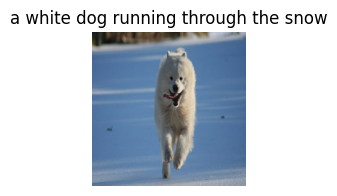

In [26]:
idx = 15

X, _ = train_dataset[idx]
caption = single_caption_generation(X, blip_model, blip_processor, max_new_tokens = 50)
img_tensor_denormalized = before_preprocessing(X, mean = imagenet_mean, std = imagenet_std)
show_image(img_tensor_denormalized, caption)

In [27]:
# idx = 15

# X, _ = train_dataset[idx]
# caption = captions_generation(X, git_model, git_processor, max_new_tokens = 50)
# img_tensor_denormalized = before_preprocessing(X, mean = imagenet_mean, std = imagenet_std)
# show_image(img_tensor_denormalized, caption)

Possiamo ora creare una lista di caption da associare alle immagini nel nostro dataset:

In [28]:
def full_captions_generation(loader, model, processor, max_new_tokens = 50):
  image_list = []
  label_list = []
  caption_list = []

  for X, y in tqdm(loader):
    batch_size = X.shape[0]
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
      out = model.generate(pixel_values = X,
                           max_new_tokens = max_new_tokens)

    for i in range(batch_size):
      caption = processor.decode(out[i], skip_special_tokens = True)
      caption_list.append(caption)

    for img, label in zip(X, y):
      image_list.append(img.clone().cpu())
      label_list.append(label.clone().cpu())


  return image_list, label_list, caption_list

train_images, train_labels, train_captions = full_captions_generation(train_loader,
                                                                      blip_model,
                                                                      blip_processor,
                                                                      max_new_tokens = 50)
test_images, test_labels, test_captions = full_captions_generation(test_loader,
                                                                   blip_model,
                                                                   blip_processor,
                                                                   max_new_tokens = 50)

100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Controlliamo se ci sono delle caption 'fuori scala' o insensate:

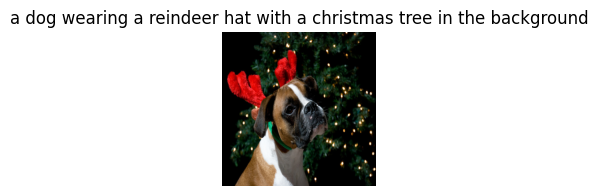

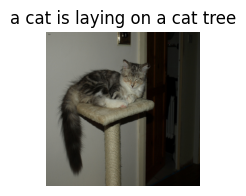

In [29]:
max_len_train = max(len(s) for s in train_captions)
longest_indices_train = [i for i, s in enumerate(train_captions) if len(s) == max_len_train]

X = train_images[longest_indices_train[0]]
caption = single_caption_generation(X, blip_model, blip_processor, max_new_tokens = 50)
img_tensor_denormalized = before_preprocessing(X, mean = imagenet_mean, std = imagenet_std)
show_image(img_tensor_denormalized, caption)

max_len_test = max(len(s) for s in test_captions)
longest_indices_test = [i for i, s in enumerate(test_captions) if len(s) == max_len_test]

X = train_images[longest_indices_test[0]]
caption = single_caption_generation(X, blip_model, blip_processor, max_new_tokens = 50)
img_tensor_denormalized = before_preprocessing(X, mean = imagenet_mean, std = imagenet_std)
show_image(img_tensor_denormalized, caption)

# (4) Caption Rewriting

Ora che abbiamo le nostre captions, possiamo procedere a renderle migliori. Per riuscire, servira' un minimo di prompt engineering. Questo procedimento duplichera' la taglia del dataset, ma in principio si potrebbero generare $N$ captions analoghe per ogni caption, rendendo il dataset molto piu' ampio (avendo sufficienti risorse e tempo).

NB: il seguente codice e' commentato perche' i file generati verranno downloadati e ricaricati.

In [30]:
# checkpoint = "HuggingFaceH4/zephyr-7b-beta"

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit = True,
#     bnb_4bit_compute_dtype = torch.float16)

# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# model = AutoModelForCausalLM.from_pretrained(
#                  checkpoint,
#                  quantization_config = bnb_config,
#                  device_map = "auto")

# tokenizer.bos_token # <s>
# tokenizer.pad_token # </s>
# tokenizer.eos_token # </s>

# tokenizer.padding_side = "left"

In [31]:
def rewrite_captions_in_batches(original_captions, model, tokenizer, batch_size = 32, max_new_tokens = 10):
    """
    original_captions: list of strings.
    """

    rewritten_captions = []
    total_captions = len(original_captions)

    for i in tqdm(range(0, total_captions, batch_size)):

        batch_captions = original_captions[i : i + batch_size]

        batch_prompts = []
        for caption in batch_captions:
            prompt = f"""
<|system|>
You are a precise caption rewriting assistant. You strictly output ONLY the rewritten text.
No introductions, no labels, no notes, no explanations.</s>
<|user|>
A large brown dog is running in the field.</s>
<|assistant|>
Brown dog running in field</s>
<|user|>
A small white cat sitting on a sofa.</s>
<|assistant|>
White cat on sofa</s>
<|user|>
{caption}
<|assistant|>
"""
            batch_prompts.append(prompt)

        inputs = tokenizer(batch_prompts, return_tensors = "pt",
                           padding = True, truncation = True).to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens = max_new_tokens,
                do_sample = False,
                # temperature = 0.8,
                pad_token_id = tokenizer.eos_token_id)

        input_length = inputs["input_ids"].shape[1] # clean the generation
        generated_responses = generated_ids[:, input_length:]

        decoded_batch = tokenizer.batch_decode(generated_responses,
                                               skip_special_tokens = True)

        rewritten_captions.extend(decoded_batch)
        torch.cuda.empty_cache()

    return rewritten_captions


# rewritten_train_captions = rewrite_captions_in_batches(train_captions, model, tokenizer, batch_size = BATCH_SIZE, max_new_tokens = 25)
# rewritten_test_captions = rewrite_captions_in_batches(test_captions, model, tokenizer, batch_size = BATCH_SIZE, max_new_tokens = 25)

In [32]:
CAPTIONS_ROOT = "/content/rewritten_captions"

def save_captions_to_txt(caption_list, filename):
  os.makedirs(CAPTIONS_ROOT, exist_ok = True)
  full_path = os.path.join(CAPTIONS_ROOT, filename)

  with open(full_path, "w", encoding = "utf-8") as f:
    for caption in caption_list:
      f.write(f"{caption}\n")

# save_captions_to_txt(rewritten_train_captions, "rewritten_train_captions.txt")
# save_captions_to_txt(rewritten_test_captions,  "rewritten_test_captions.txt")

# shutil.make_archive(CAPTIONS_ROOT, 'zip', CAPTIONS_ROOT)
# files.download(f"{CAPTIONS_ROOT}.zip")

In [33]:
!unzip -q -o rewritten_captions.zip -d rewritten_captions

with open(f"{CAPTIONS_ROOT}/rewritten_train_captions.txt", "r") as f:
    rewritten_train_captions = f.read().splitlines()

with open(f"{CAPTIONS_ROOT}/rewritten_test_captions.txt", "r") as f:
    rewritten_test_captions = f.read().splitlines()

Diamo un'occhiata alle nuove captions generate:

In [34]:
rewritten_test_captions

['Two dogs with heads together on couch',
 'White dog standing in snow',
 'Fluffy cat on carpet',
 'Fluffy orange cat on bed',
 'Cat on blanket looking up',
 'White dog standing in grassy field',
 'Dog standing in grass with frisbee',
 'Dog sitting on sidewalk',
 'White dog on beach by ocean',
 'Dog standing on tiled floor',
 'Dog with white collar',
 'Cat on floor next to door',
 'White dog with leash on leash',
 'White dog with pink bow running on road',
 'Woman in white shirt and sunglasses holding dog',
 'Cat on scratching post',
 'Dog with tongue out resting on floor',
 'Dog standing in field of grass',
 'Cat lying on white wall',
 'White dog with tongue out standing in snow',
 'White dog running down wooden path',
 'Dog with tongue out',
 'Fluffy cat on window sill',
 'Fluffy white-faced cat',
 'Dog with tennis ball in mouth lying on floor',
 'Cat on top of refrigerator',
 'Cat on table with mirror in background',
 'Small dog on floor with owner',
 'Dog with tennis ball in mouth'

# (5) Image Generation/Data Augmentation

Possiamo ora generare le immagini, sia dalle captions originali, sia da quelle risctitte.

NB: il codice e' commentato per gli stessi motivi di cui sopra.

In [35]:
# model_id = "SG161222/Realistic_Vision_V5.1_noVAE"

# pipe = StableDiffusionPipeline.from_pretrained(model_id,
#                                                torch_dtype = torch.float16).to(device)

In [36]:
def generate_images_from_captions(captions_list, pipe, resize = 384):
  generated_images = []

  negative_prompt = "cartoon, 3d, anime, sketch, low quality, distortion, watermark, text, bad anatomy, bad hands"

  for i, caption in enumerate(tqdm(captions_list)):

    with torch.no_grad():
      image = pipe(
                caption,
                negative_prompt = negative_prompt,
                num_inference_steps = 30,
                guidance_scale = 10,
                height = resize,
                width = resize).images[0]

      generated_images.append(image)

  return generated_images

# synthetic_train_images = generate_images_from_captions(train_captions, pipe, RESIZE)
# synthetic_test_images = generate_images_from_captions(test_captions, pipe, RESIZE)

# synthetic_rewritten_train_images = generate_images_from_captions(rewritten_train_captions, pipe, RESIZE)
# synthetic_rewritten_test_images = generate_images_from_captions(rewritten_test_captions, pipe, RESIZE)

In [37]:
IMAGES_ROOT = "/content/synthetic_dataset"

def save_images_to_folder(image_list, folder_name, prefix = "train"):
  full_path = os.path.join(IMAGES_ROOT, folder_name)
  os.makedirs(full_path, exist_ok = True)
  for i, img in enumerate(image_list):
    filename = f"{prefix}_{i}.jpg"
    img.save(os.path.join(full_path, filename), "JPEG", quality = 95)

# save_images_to_folder(synthetic_train_images,
#                       "synthetic_train_images",
#                       "synthetic_train")
# save_images_to_folder(synthetic_test_images,
#                       "synthetic_test_images",
#                       "synthetic_test")

# save_images_to_folder(synthetic_rewritten_train_images,
#                       "synthetic_rewritten_train_images",
#                       "synthetic_rewritten_train")
# save_images_to_folder(synthetic_rewritten_test_images,
#                      "synthetic_rewritten_test_images",
#                       "synthetic_rewritten_test")

# shutil.make_archive(IMAGES_ROOT, 'zip', IMAGES_ROOT)
# files.download(f"{IMAGES_ROOT}.zip")

In [38]:
!unzip -q -o synthetic_dataset.zip -d synthetic_dataset

def load_images(folder_name, prefix = "train"):
  full_path = os.path.join(IMAGES_ROOT, folder_name)
  loaded_images = []
  i = 0

  while os.path.exists(f"{full_path}/{prefix}_{i}.jpg"):
    loaded_images.append(Image.open(f"{full_path}/{prefix}_{i}.jpg"))
    i += 1

  return loaded_images

synthetic_train_images = load_images("synthetic_train_images",
                                     "synthetic_train")
synthetic_test_images = load_images("synthetic_test_images",
                                    "synthetic_test")

synthetic_rewritten_train_images = load_images("synthetic_rewritten_train_images",
                                               "synthetic_rewritten_train")
synthetic_rewritten_test_images = load_images("synthetic_rewritten_test_images",
                                              "synthetic_rewritten_test")

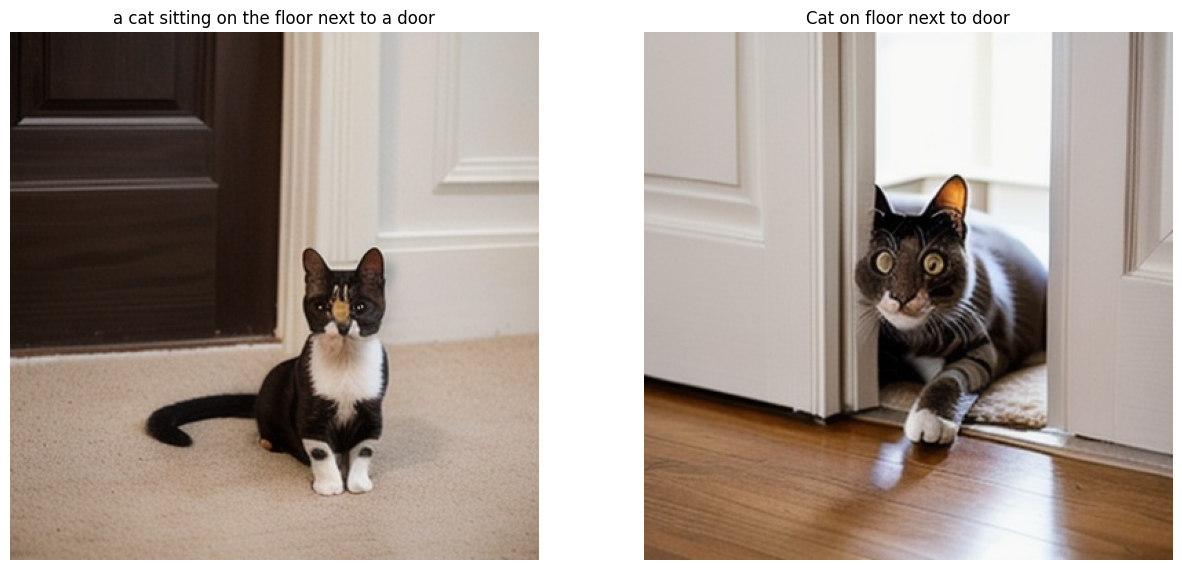

In [102]:
idx = 55
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (15, 15))
axes[0].imshow(synthetic_train_images[idx])
axes[0].set_title(f"{train_captions[idx]}")
axes[0].axis('off')
axes[1].imshow(synthetic_rewritten_train_images[idx])
axes[1].set_title(f"{rewritten_train_captions[idx]}")
axes[1].axis('off')
plt.show()

Dopo aver visionato un certo numero di immagini generate dalle caption originale e da quelle riscritte, si puo' osservare che le immagini generate da quelle originali sono migliori in qualita'. Pertanto si decide di procedere con quest'ultime.

# (6) Augmented Dataset Creation

Adesso abbiamo un train- e test-dataset con rispettive labels, e una lista di nuove immagini generate, sia di train che di test. Dobbiamo quindi trasformare questa lista in un Dataset (e DataLoader) per poter successivamente allenare il modello. Da specifiche del progetto, lavoreremo con:

- `train_dataset` e `test_dataset`;
- `augmented_train_dataset` e `augmented_test_dataset`, che comprenderanno `train_dataset` e `test_dataset` e le immagini sintetiche aggiuntive.

In [40]:
class AugmentedDataset(Dataset):
  def __init__(self, base_dataset, synthetic_images: list = None, transform = None):
    """
    base_dataset: a PyTorch Dataset object;
    synthetic_images: a list of generated PIL images;
    transform: a set of PyTorch transformations (should match the transf. of base_dataset)
    """
    super().__init__()

    self.base_dataset = base_dataset
    self.synthetic_images = synthetic_images
    self.transform = transform
    self.base_len = len(base_dataset)

  def __len__(self):
    return len(self.base_dataset) + len(self.synthetic_images)

  def __getitem__(self, idx):
    if idx < self.base_len:
      return self.base_dataset[idx]

    else:
      synthetic_idx = idx - self.base_len # restart the index
      synthetic_img = self.synthetic_images[synthetic_idx]

      if self.transform:
        synthetic_img = self.transform(synthetic_img)

      _, label = self.base_dataset[synthetic_idx] # this works only because the generated images
                                                  # are paired with the original ones

      return synthetic_img, label

transforms = T.Compose([
                T.Resize(size = (RESIZE, RESIZE)), # it is just a check
                T.ToTensor(),
                T.Normalize(mean = imagenet_mean, std = imagenet_std)])

augmented_train_dataset = AugmentedDataset(train_dataset, synthetic_train_images, transforms)
augmented_test_dataset = AugmentedDataset(test_dataset, synthetic_test_images, transforms)

augmented_train_loader = DataLoader(augmented_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
augmented_test_loader = DataLoader(augmented_test_dataset, batch_size = BATCH_SIZE, shuffle = False)

# (7) Training

Possiamo quindi procedere ad allenare un modello. Si testeranno un modello su cui fare transfer learning ed uno da allenare da zero.


In [82]:
################## BASELINE MODEL: EfficientNet_B0 ##################
efficientnet_full = efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in efficientnet_full.features.parameters():
  param.requires_grad = False

################## MANUAL FEATURE EXTRACTOR ##################
class SimpleFeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

  def forward(self, X): # X.shape = [B, C, RESIZE, RESIZE]
    X = self.features(X)      # X.shape: [B, 128, ..., ...]
    return X

my_extractor = SimpleFeatureExtractor()

Il modello baseline qui sotto aggiunge il minor numero possibile di parametri, nel senso che la testa di classificazione non ha layer nascosti. In pratica, e' come fare logistic regression dopo l'estrazione delle features:

In [83]:
class BaselineModel(nn.Module):
  def __init__(self, backbone: nn.Module, N_f: int, N_classes: int):
    """
    backbone: a nn.Module, which extracts the features;
    N_f: the number of feature maps in output of the backbone.
    N_classes: the number of classes of classification;
    """
    super().__init__()
    self.features = backbone
    self.N_f = N_f
    self.classification_head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), # X.shape: [B, N_f, 1, 1]
        nn.Flatten(), # X.shape: [B, N_f]
        nn.Linear(self.N_f, N_classes)) # X.shape: [B, N_classes]

  def forward(self, X): # X.shape: [B, C = 3, RESIZE, RESIZE]
    X = self.features(X)  # X.shape: [B, N_f, ..., ...]
    X = self.classification_head(X) # X.shape: [B, N_classes]
    return X

X_example = torch.randn((1, 3, RESIZE, RESIZE)) # useful to uncover automatically N_f, the number of filters for the models

N_f_efficientnet = efficientnet_full.features(X_example).shape[1]
N_f_my_extractor = my_extractor(X_example).shape[1]

NB: sui dataset aumentati, si useranno `augmented_train_loader`ed il `test_loader`non aumentato!

## EfficientNet

Vediamo prima il comportamento del modello sul dataset base:

100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


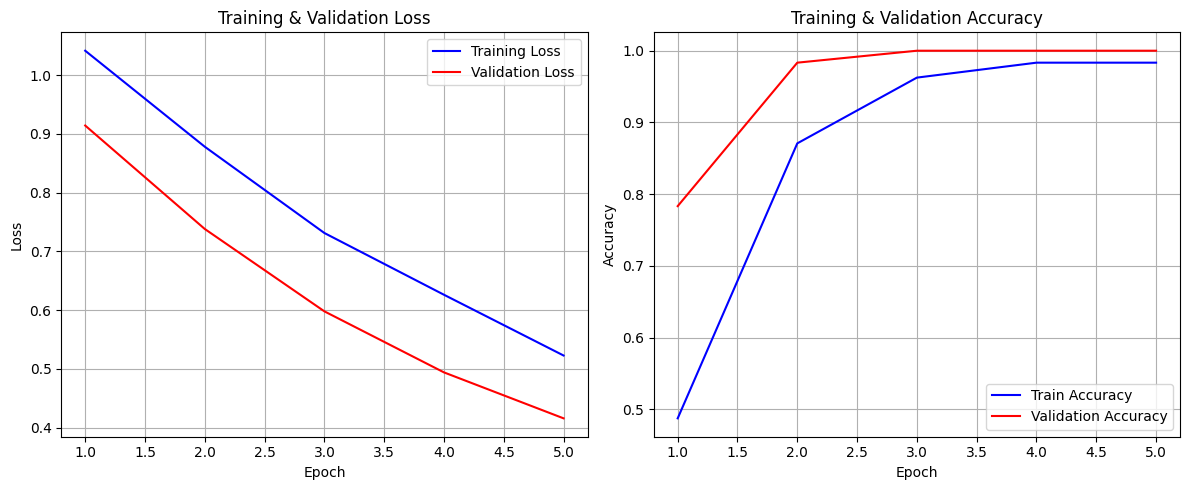

In [64]:
my_efficientnet = BaselineModel(backbone = efficientnet_full.features,
                                N_f = N_f_efficientnet,
                                N_classes = 3).to(device)

EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = my_efficientnet.parameters(), lr = 0.0005)
early_stopping = EarlyStopping(path = './checkpoint.pt')

[train_losses, train_accuracies, test_losses, test_accuracies], [y_train, yhat_train, y_test, yhat_test] = \
                train_classification(my_efficientnet, loss_fn, optimizer,
                                     train_loader, test_loader,
                                     epochs = EPOCHS, verbose = False,
                                     confusion_matrix_data = True,
                                     early_stopping = early_stopping)

training_results(train_losses, train_accuracies, test_losses, test_accuracies, size = (12, 5))

,Accuracy,F1-score,Precision,Recall
Train,1.0,1.0,1.0,1.0
Validation/Test,1.0,1.0,1.0,1.0


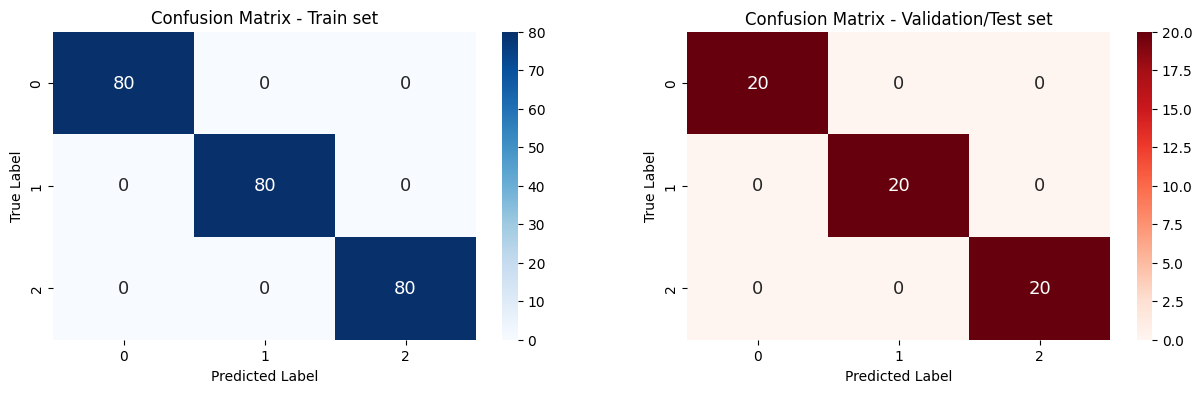

In [65]:
metrics_train, metrics_val, metrics_df, confusion_matrices = metrics_report(y_train, yhat_train, y_test, yhat_test,
                                                                            verbose = True, size = (15, 4))

Ed ora su quello aumentato:

100%|██████████| 50/50 [05:22<00:00,  6.45s/it]


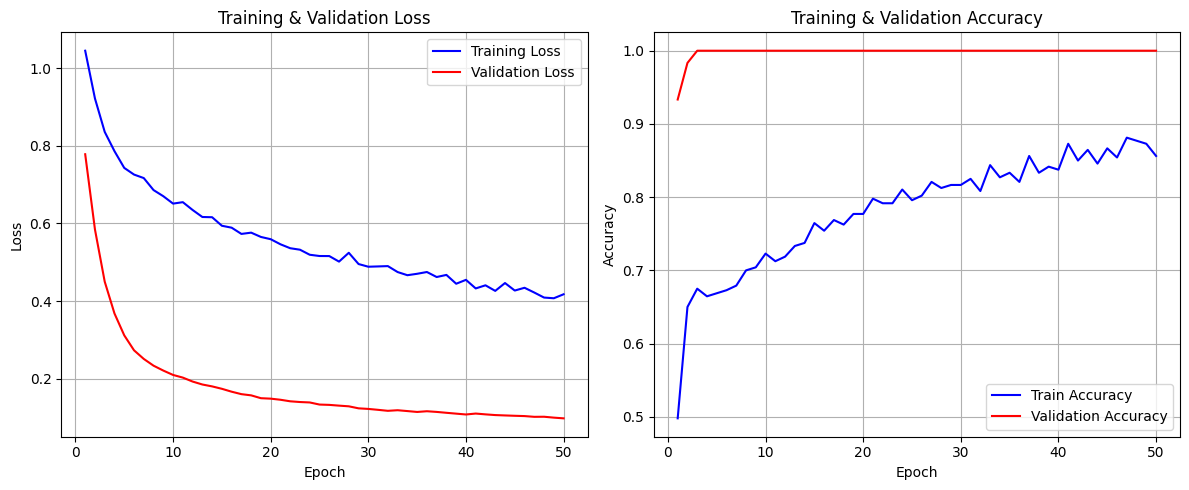

In [100]:
my_efficientnet = BaselineModel(backbone = efficientnet_full.features,
                                N_f = N_f_efficientnet,
                                N_classes = 3).to(device)

EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = my_efficientnet.parameters(), lr = 0.0005)
early_stopping = EarlyStopping(path = './checkpoint.pt')

[train_losses, train_accuracies, test_losses, test_accuracies], [y_train, yhat_train, y_test, yhat_test] = \
                train_classification(my_efficientnet, loss_fn, optimizer,
                                     augmented_train_loader, test_loader,
                                     epochs = EPOCHS, verbose = False,
                                     confusion_matrix_data = True,
                                     early_stopping = early_stopping)

training_results(train_losses, train_accuracies, test_losses, test_accuracies, size = (12, 5))

,Accuracy,F1-score,Precision,Recall
Train,0.897917,0.898172,0.900349,0.897917
Validation/Test,1.000000,1.000000,1.000000,1.000000


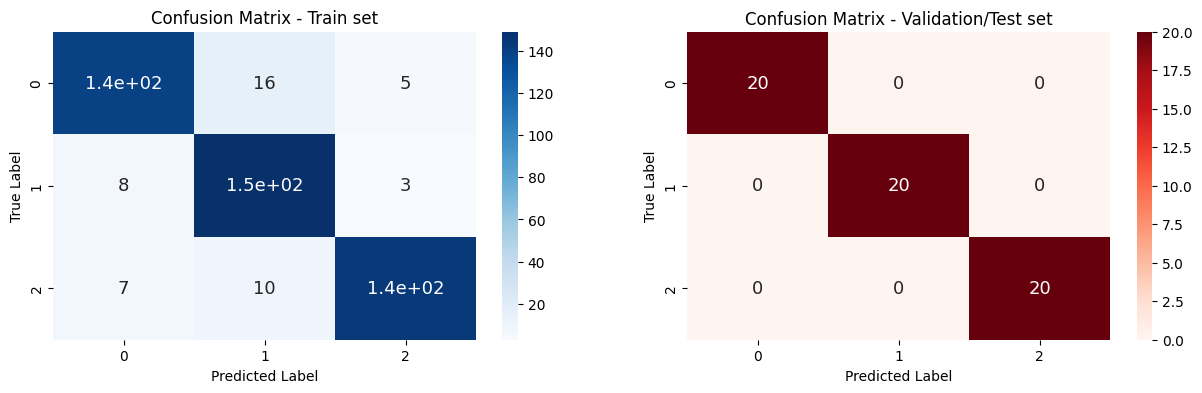

In [101]:
metrics_train, metrics_val, metrics_df, confusion_matrices = metrics_report(y_train, yhat_train, y_test, yhat_test,
                                                                            verbose = True, size = (15, 4))

## My Model

 64%|██████▍   | 32/50 [01:43<00:58,  3.24s/it]


Early stopping triggered.


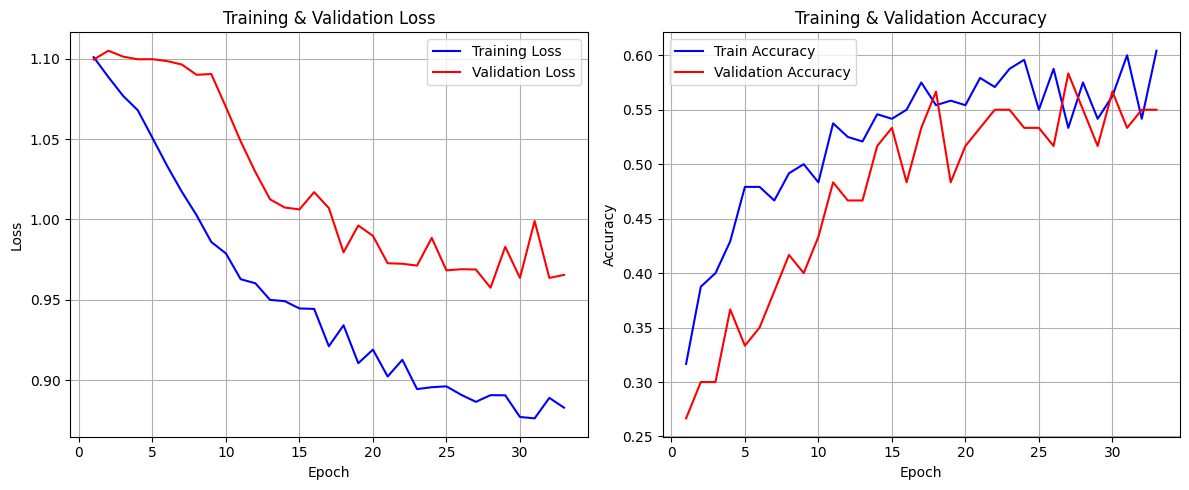

In [94]:
my_extractor = SimpleFeatureExtractor()
my_model = BaselineModel(backbone = my_extractor,
                         N_f = N_f_my_extractor,
                         N_classes = 3).to(device)

EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = my_model.parameters(), lr = 0.0005)
early_stopping = EarlyStopping(path = './checkpoint.pt')

[train_losses, train_accuracies, test_losses, test_accuracies], [y_train, yhat_train, y_test, yhat_test] = \
                train_classification(my_model, loss_fn, optimizer,
                                     train_loader, test_loader,
                                     epochs = EPOCHS, verbose = False,
                                     confusion_matrix_data = True,
                                     early_stopping = early_stopping)

training_results(train_losses, train_accuracies, test_losses, test_accuracies, size = (12, 5))

,Accuracy,F1-score,Precision,Recall
Train,0.616667,0.609445,0.617937,0.616667
Validation/Test,0.550000,0.539287,0.555024,0.550000


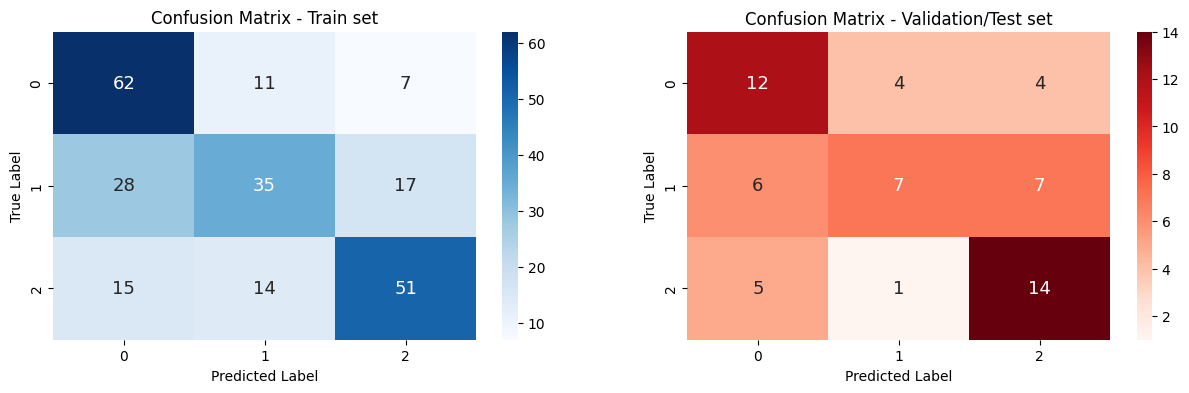

In [95]:
metrics_train, metrics_val, metrics_df, confusion_matrices = metrics_report(y_train, yhat_train, y_test, yhat_test,
                                                                            verbose = True, size = (15, 4))

Ed ora su quello aumentato:

 52%|█████▏    | 26/50 [02:40<02:28,  6.17s/it]


Early stopping triggered.


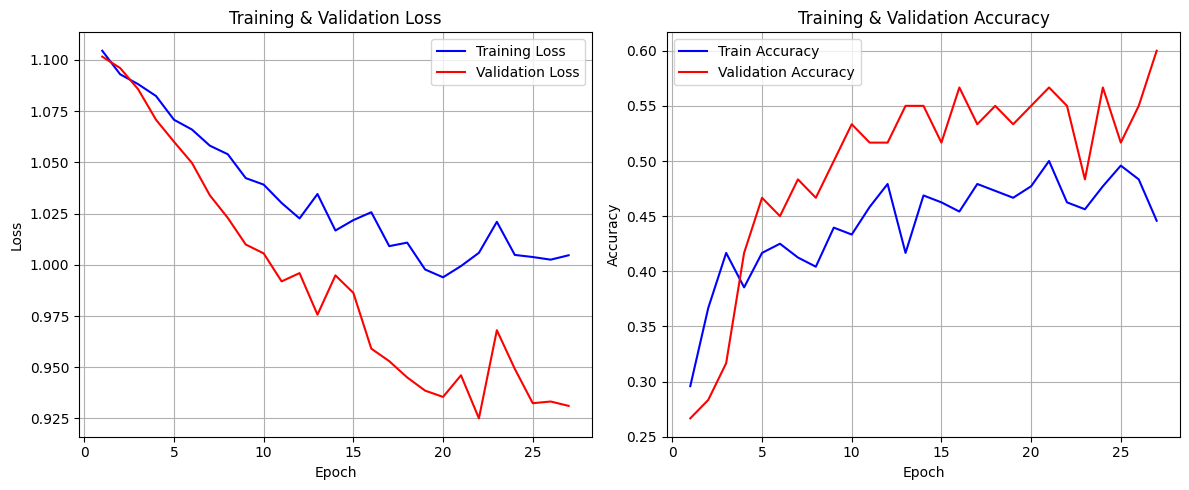

In [96]:
my_extractor = SimpleFeatureExtractor()
my_model = BaselineModel(backbone = my_extractor,
                         N_f = N_f_my_extractor,
                         N_classes = 3).to(device)

EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = my_model.parameters(), lr = 0.0005)
early_stopping = EarlyStopping(path = './checkpoint.pt')

[train_losses, train_accuracies, test_losses, test_accuracies], [y_train, yhat_train, y_test, yhat_test] = \
                train_classification(my_model, loss_fn, optimizer,
                                     augmented_train_loader, test_loader,
                                     epochs = EPOCHS, verbose = False,
                                     confusion_matrix_data = True,
                                     early_stopping = early_stopping)

training_results(train_losses, train_accuracies, test_losses, test_accuracies, size = (12, 5))

,Accuracy,F1-score,Precision,Recall
Train,0.497917,0.482259,0.497198,0.497917
Validation/Test,0.550000,0.535127,0.569349,0.550000


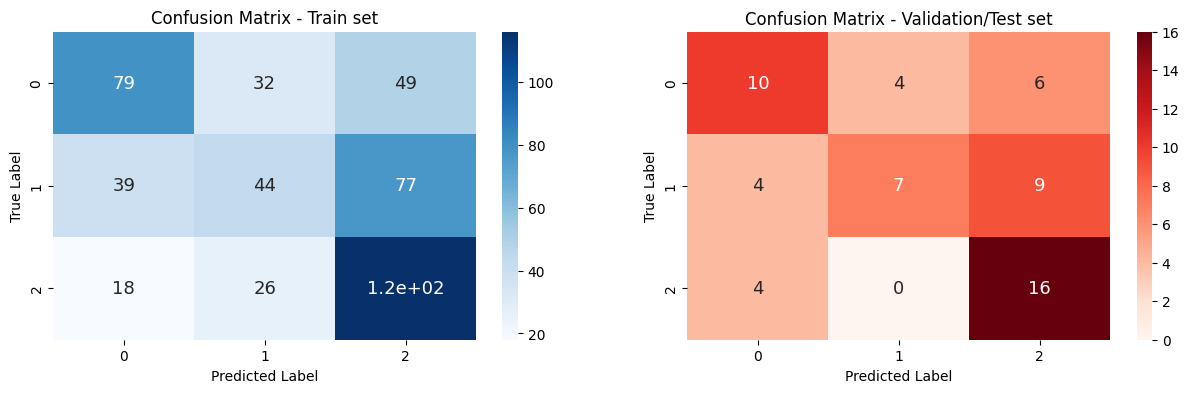

In [97]:
metrics_train, metrics_val, metrics_df, confusion_matrices = metrics_report(y_train, yhat_train, y_test, yhat_test,
                                                                            verbose = True, size = (15, 4))

# (8) Final Discussion

Come ci si poteva aspettare, i risultati ottenuti con EfficientNet sono inconcludenti (a livello di POC), nel senso che EfficientNet conosce bene la forma degli animali (essendo allenato su ImageNet) e di conseguenza, raggiunge subito prestazioni altissime sia sul dataset standard che su quello aumentato.

L'utilizzo del modello custom rende la POC piu' solida. Come ci si aspetta, allenare una rete custom su 200/300 immagini non ha senso, perche' servono migliaia di immagini per far si che una rete inizi a riconoscere bordi, forme, ecc. Segue che si arriva velocemente all'overfitting, con prestazioni molto migliori sul train-set piuttosto che sul test-set. Il dataset aumentato funziona come regolatore, riducendo l'overfitting e dando la possibilita' di allenare davvero il modello in modo soddisfacente. Anche se qui non si e' fatta una ricerca specifica/approfondita degli iperparametri (con splitting train-val-test) ne' del modello custom migliore possibile (dato che e' solo un POC), i segni di cio' che ci si aspettava sono evidenti.